# Inference

This notebook demonstrates a simple method to estimate parameters from data generated by our model. We'll generate some synthetic data, then do grid-search maximum-likelihood to estimate the parameters. In these experiments, we will fix $\alpha = 0$ and therefore attempt to learn $\beta$ and $\lambda$. Much smarter ways to do this are likely possible. 

The model we are using here is: 

$$\mathbf{A}^{(t+1)} = \lambda \mathbf{A}^{(t)} + (1-\lambda)\Delta(\mathbf{s}^{(t)})\;,$$

where $\mathbf{s}^{(t)} = \phi(\mathbf{A}^{(t)})$ is the SpringRank vector of $\mathbf{A}^{(t)}$ and $\Delta(\mathbf{s})$ is our standard increment function. I have made a small modification though: $\Delta$ is allowed to make multiple hires simultaneously, rather than just one at a time (great idea, Nicole!). 

In [2]:
import numpy as np
from SpringRank import SpringRank
# from itertools import chain
import matplotlib.pyplot as plt
from py import estimation
%matplotlib inline

# Parameters

In [4]:
n = 70                                     # number of departments
beta = 2.36
lam = .86                                   # lambda
n_rounds = 40                             # number of iterations 
T0 = np.random.randint(1, 4, size = (n,n)) # initial state

# Generate Synthetic Data

In [5]:
T = estimation.synthetic_time_series(n, beta, lam, n_rounds, T0)

The "data" $T$ is organized as a 3-array in which the first axis gives the time-step, and the second and third axes give the cumulative hiring matrix. The entry $t_{ij}$ gives the number of times that department $i$ has hired from department $j$. 

In [6]:
T[10] # state at timestep 10

array([[ 4.,  5.,  4., ..., 11.,  9.,  9.],
       [12., 10.,  9., ..., 10., 12.,  9.],
       [ 8.,  8.,  2., ...,  4.,  5.,  8.],
       ...,
       [ 6.,  5.,  7., ...,  7., 10., 11.],
       [10.,  9., 14., ...,  7.,  7.,  7.],
       [ 7.,  6.,  7., ...,  5., 10.,  6.]])

We can visualize the vector $\gamma$ for this data as it evolves over time: 

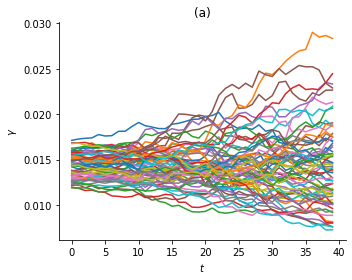

In [7]:
def plot_gammas(T, lam, title = '', figsize = (5,4)):
    A = estimation.state_matrix(T, lam)
    GAMMA = np.zeros((n_rounds, n))
    for k in range(n_rounds):
        GAMMA[k] = estimation.compute_gamma(A[k], beta)
    
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    
    for l in range(n):
        ax.plot(GAMMA[:,l])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set(xlabel = r'$t$',
           ylabel = r'$\gamma$',
           title = title)
    
    plt.tight_layout()

plot_gammas(T, lam, '(a)')
plt.savefig('fig/series_1.png', dpi = 300)

# Estimation

At the moment, we have a very dumb, proof-of-concept algorithm. It evaluates the likelihood for every combination of $\beta$ and $\lambda$ in a user-specified range and returns a matrix of the results. 

In [8]:
lam_grid = 51 # resolution in $\lambda$
b_grid = 51   # resolution in $\beta$

LAMBDA = np.linspace(.5, 1, lam_grid) # lambda values at which to evaluate
BETA = np.linspace(1, 5, b_grid)            # beta values at which to evaluate

# compute the likelihood at each combination of lambda and beta. 
# might take a little while depending on lam_grid, beta_grid, n, and n_rounds

M = estimation.likelihood_surface(T, LAMBDA, BETA) 

We can then query $M$ for results. For example, we can find the maximum-likelihood estimates, with rough error bars from the Fisher Information. The confidence intervals usually don't include the true values, which is unfortunate and something to think about. May indicate bugs. 

In [9]:
def print_estimates(M, beta, lam):
    
    ix = np.where(M == M.max())
    beta_hat = BETA[ix[1]][0]
    lambda_hat = LAMBDA[ix[0]][0]
    
    # Fisher Information Matrix
    H = estimation.hessian(M, LAMBDA, BETA)[ix][0]
    cov = 2*np.linalg.inv(H)
    lambda_sig = np.abs(cov[0]).sum()
    beta_sig = np.abs(cov[1]).sum() # rough upper bound (Gersgorin-type)
    lambda_interval = np.round([lambda_hat - lambda_sig,lambda_hat + lambda_sig], 4)
    beta_interval = np.round([beta_hat - beta_sig,beta_hat + beta_sig], 3)
    
    print('The estimates are (roughly) beta in ' + str(beta_interval)  + ' and lambda in ' + str(lambda_interval) + '.')
    print('The true values were beta = ' + str(beta) + ' and lambda = ' + str(lam) + '.')
    
print_estimates(M, beta, lam)

The estimates are (roughly) beta in [2.273 2.287] and lambda in [0.8493 0.8507].
The true values were beta = 2.36 and lambda = 0.86.


We can also visualize the likelihood surface. The black dot is the true parameter combination, and the hollow dot is the estimate. 

In [10]:
def plot_surface(M, BETA, LAMBDA, beta, lam, title = '', figsize = (5,4)):
    
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)

    xg, yg = np.meshgrid(BETA, LAMBDA)

    im = ax.contourf(xg, yg, M, levels = 100)
    ax.contour(xg, yg, M, 
               levels = np.linspace(M.max()-50, 
                                    M.max(), 10), 
               linewidths = .5, 
               colors = 'black', 
               linestyles = 'solid')

    plt.colorbar(im)

    ax.scatter(beta, lam, color = 'black')

    ax.set(xlabel = r'$\beta$',
           ylabel = r'$\lambda$', 
           title = title)

    ix = np.where(M == M.max())
    beta_hat = BETA[ix[1]][0]
    lambda_hat = LAMBDA[ix[0]][0]
    
    ax.scatter(beta_hat, lambda_hat, color = 'black', facecolor = 'None')
    plt.tight_layout()

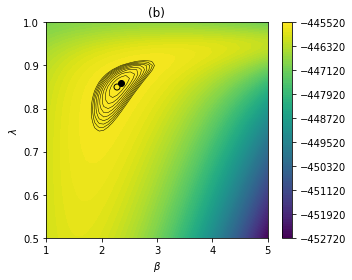

In [11]:
plot_surface(M, BETA, LAMBDA, beta, lam, title = '(b)')
plt.savefig('fig/surface_1.png', dpi = 300, figsize = (4,3))

# Harder Cases

The above case seems to work very well, but some parameter combinations are harder. 

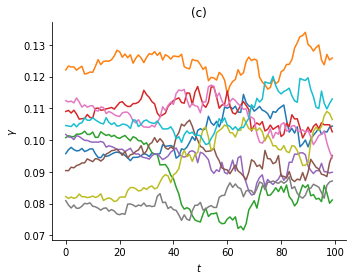

In [68]:
beta = 1.5
lam = .95
T = estimation.synthetic_time_series(n, beta, lam, n_rounds, T0)
plot_gammas(T, lam, '(c)')
plt.savefig('fig/series_2.png', dpi = 300)

In [69]:
M = estimation.likelihood_surface(T, LAMBDA, BETA) 
print_estimates(M, beta, lam)

The estimates are (roughly) beta in [1.578 1.702] and lambda in [0.9487 0.9513].
The true values were beta = 1.5 and lambda = 0.95.


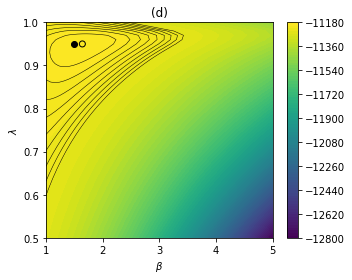

In [70]:
plot_surface(M, BETA, LAMBDA, beta, lam, title = '(d)')
plt.savefig('fig/surface_2.png', dpi = 300)

In this case, the estimated value of $\beta$ is somewhat higher than the true value, as is $\lambda$. I think this is probably because, if we observe a roughly egalitarian state over long time-periods, that could be EITHER because there is very little change in general ($\lambda$ is large) or because the egalitarian state is quite stable $\beta$ is small. In this regime, the model can easily be confused, and attribute effects truly due to small $\beta$ instead to large $\lambda$. 

Of course, data that is NOT truly generated from our model will pose even greater challenges. 

# Todo: 

- Estimate the Fisher information in order to place give standard error bars on the parameter estimates. (possibly bugged?)
- Systematic experiments
- Real data??!!?!!!?